# Prediction of Bike Sharing patterns

This project analyzes data about bike rentals during a two-year period in order to be able to obtain behavorial patterns and optimize availability of bikes according to the predicted demand.

We will be using Pandas to load and analyze the data, Numpy for calculations and Matplotlib/Seaborn for graphics 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load and prepare the data

The dataset contains to files: one with the daily usage and another one with the hourly usage of the service. We have data from January 1st, 2011 to December 31st, 2012.

We will be using the hourly dataset for the training but can also use the daily values for hypothesis validation.

The information about the dataset used can be found here [Readme.txt](./dataset/Readme.txt)

In [2]:
data_path = './dataset/'

rides = pd.read_csv(data_path + 'hour.csv')

# # In case we wanted to use this information for hypothesis validation
# rides_daily = pd.read_csv(data_path + 'day.csv')

rides.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Let's take a look at all the fields/columns:

In [3]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


## About the data

In the table above we can identify these columns.

Field      | Description                                                               | Comments
:----------|:--------------------------------------------------------------------------|:----------------
instant    | Unique identifier, sequence                                               | Not used for predictions ***Delete***
dteday     | Date string in format yyyy-mm-yy                                          | Redundant ***Delete***
season     | Season of the year, numbers 1 to 4 represent the four seasons             | *Categorical*
yr         | Year (sequential for years... te dataset only has two years, so 0 is 2011 and 1 is 2012 | *Categorical*
mnth       | Month number (the same as the mm in **dteday**                            | *Categorical*
hr         | Hour of the day (0 to 23, format 24h)                                     | *Categorical*
holiday    | Boolean representing whether the day us a holiday (1 for true, 0 for false) | *Categorical*
weekday    | Boolean representing whether it is a working day or a weekend (1 for working day, 0 for weekend) | *Categorical*
workingday | Boolean representing if the day is neither holiday nor weekend            | Redundant ***Delete***
weathersit | Weather situation. This is a categorical with 4 possible values. Reffer to the readme file for more details | *Categorical*
temp       | Temperature (in degrees Celsius). It was normalized by dividing it by the max value (41) |
atemp      | Perceived temperature (in degrees Celsius). It was normalized by dividing it by the max value (50) |
hum        | Relative humidity (in percentage). It was normalized by dividing it by the max value (100) | 
windspeed  | Windspeed (km/h). It was normalized by dividing it by the max value (67)  | 
casual     | Number of bikes used by non-registered users                              | Won't be using it on this analysis ***Delete***  
registered | Number of bikes used by registered users                                  | Won't be using it on this analysis ***Delete***
cnt        | Total number of bikes used                                                | **This is the field we want to predict**

Below is a plot showing the number of bike riders over the first 20 days (this is just an approximation, since not all days will have 24 records on the original file). 

It is possible to identify a couple of interesting factors:
* On each period of (aproximately) 7 days there are two days with way less users (presumably weekends)
* On the same day it is possible to identify different spikes (remember we are showing hourly records, not daily)



<AxesSubplot:xlabel='dteday'>

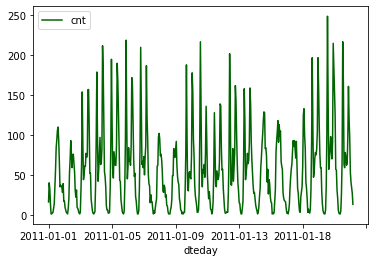

In [4]:
rides[:24*20].plot(x='dteday', y='cnt', color='darkgreen')


### Categorical data
On the previous table we identified some information as categorical data (with non-continuous values). For that kind of information we need to create a boolean column for each possible category. And also get rid of the original column.

For this we will use the function `get_dummies()`, from tha Pandas library.

In [5]:
categorical_fields = ['season',  'yr', 'mnth', 'hr', 'holiday', 'weekday', 'weathersit']
for field in categorical_fields:
    dummies = pd.get_dummies(rides[field], prefix=field, drop_first=False) # create the dummy columns
    rides = pd.concat([rides, dummies], axis=1)                            # add the dummies to the table

fields_to_drop = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'weathersit', 'instant', 'dteday', 'workingday', 'casual', 'registered']
data = rides.drop(fields_to_drop, axis=1)  # drop the original categorical columns and the redundant variables
data.head()

,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,yr_0,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0.24,0.2879,0.81,0.0,16,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
1,0.22,0.2727,0.80,0.0,40,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2,0.22,0.2727,0.80,0.0,32,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
3,0.24,0.2879,0.75,0.0,13,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
4,0.24,0.2879,0.75,0.0,1,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0


### Scaling target variables

This first step is optional and should not have any effect on the result. The original values for temperature (real and perceived), humidity and windspeed were already normalized in the original dataset by dividing them by their highest value. 

We could use our normalization on top of these values, but instead we are first reverting that change.

In [6]:
data['temp'] = data['temp'] * 41
data['atemp'] = data['atemp'] * 50
data['hum'] = data['hum'] * 100
data['windspeed'] = data['windspeed'] * 67

data[['temp','atemp','hum','windspeed']].tail()

,temp,atemp,hum,windspeed
17374,10.66,12.880,60.0,11.0014
17375,10.66,12.880,60.0,11.0014
17376,10.66,12.880,60.0,11.0014
17377,10.66,13.635,56.0,8.9981
17378,10.66,13.635,65.0,8.9981


To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [7]:
quant_features = ['cnt', 'temp', 'atemp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
    
data.head()

,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,yr_0,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,-1.334609,-1.093249,0.947345,-1.553844,-0.956312,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
1,-1.438475,-1.181698,0.895513,-1.553844,-0.823998,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2,-1.438475,-1.181698,0.895513,-1.553844,-0.868103,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
3,-1.334609,-1.093249,0.636351,-1.553844,-0.972851,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
4,-1.334609,-1.093249,0.636351,-1.553844,-1.039008,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0


### Splitting the data into training, testing, and validation sets

First let's separate our data into *features*  and *targets*. For this excercise we dropped the variables `casual` and `registered` and we will focus the predictions on the total number of users `cnt`.

In [8]:
target_fields = ['cnt']
features, targets = data.drop(target_fields, axis=1), data[target_fields]


We'll save the data for ***approximately*** **21 days** to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

Instead of taking the test data from the beginning of the end of the dataset, the following function takes a continuous block of the size specified, at a random position, and returns that subset and  the set original minus the subset, for both features and targets.

In [9]:
from random import randint

def dslicer(features, targets, size, tail=False):
    ''' Slice the features, and targets sets according to the specified size. 
        
            Arguments
            ---------
            
            features: NumPy array, each row is one data record
            targets:  Numpy array, each row is a target record
            size:     number of elements for the subset
            tail:     if true, always take the records from the end of the arrays, useful for timeseries
        
        '''
    
    assert len(features) == len(targets), 'Sizes don\'t match'
    assert size != 0 and size < len(features), 'Target size cannot be 0'
    
    maxlen = len(features) - size

    if tail:
        cutpoint = maxlen
    else:
        cutpoint = randint(0, maxlen)
    
    subfeatures = features[cutpoint:cutpoint+size]
    subtargets  = targets[cutpoint:cutpoint+size]

    remainfeatures = np.concatenate((features[:cutpoint], features[cutpoint+size:]), axis=0)
    remaintargets  = np.concatenate((targets[:cutpoint], targets[cutpoint+size:]), axis=0)

    return subfeatures, subtargets, remainfeatures, remaintargets

In [10]:
features_vect = features.values
targets_vect = targets.values

## Since we have 24 hours for most days in the dataset, using a size of 21*24 will give us _approximately_ 21 days
test_features, test_targets, main_features, main_targets = dslicer(features.values, targets_vect, 21*24, tail=False) 
print('Shape test: ', test_features.shape)    # ti verify the size of each resulting slice
print('Shape main: ', main_features.shape)

Shape test:  (504, 59)
Shape main:  (16875, 59)


We'll split the main data into two sets, one for training and one for validating as the network is being trained. 

*Note:* Since this is time series data, we should be training on historical data, then try to predict on future data (the validation set). Calling `dslicer` with the `tail` parameter set to **True** would do the trick. This applies also for the test set above. You can give it a try.

In [11]:
## Let's take 60 days for our validation set
val_features, val_targets, train_features, train_targets = dslicer(main_features, main_targets, 60*24, tail=False)
print('Shape val: ', val_features.shape)
print('Shape train: ', train_features.shape)


Shape val:  (1440, 59)
Shape train:  (15435, 59)


## Building the network

<img src="./OIP.jpg" width=400px caption="Sample neural network">

The network implemented below will only have two layers: the hidden and the output.

A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

For the hidden layer we will be using a sigmoid activation function:

$f(x)=\frac{1}{1+e^{-x}}$

and for the backpropagation we will have its derivative:

$f'(x)= {f(x)}\cdot{(1 - f(x)}$

The output layer will only have one value and is used for regression. It's output is the same as its input, so the activation function for that layer is the identity function, or $f(x) = x$, and its derivative $f'(x) = 1$


In [12]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes  = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        # Implementation of sigmoid function for activation on the hidden layer.
        self.activation_function = lambda x : 1 / (1 + np.exp(-x)) 
                    

    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''

        n_records = features.shape[0]

        # The vectors for the weight-deltas have the same shape as the weight vectors
        delta_weights_i_h = np.zeros_like(self.weights_input_to_hidden)
        delta_weights_h_o = np.zeros_like(self.weights_hidden_to_output)
        
        # For each record in the batch
        for X, y in zip(features, targets):
            
            # One forward pass
            final_outputs, hidden_outputs = self.forward_pass_train(X)  
            
            # Calculate backpropagation (deltas for weights) 
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        
        # After processing the whole batch, update weights
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):
        ''' Implement forward pass here 
         
            Arguments
            ---------
            X: features ndarray

        '''
        
        ### Forward pass ###
        
        # Calculate hidden layer, using internal activation function
        hidden_inputs = X.dot(self.weights_input_to_hidden) 
        hidden_outputs = self.activation_function(hidden_inputs) 

        # Calculate output layer. There is no activation function here, or f(x) = x
        final_inputs = hidden_outputs.dot(self.weights_hidden_to_output) 
        final_outputs = final_inputs 
        
        # Return both layers (output and hidden)
        return final_outputs, hidden_outputs
    

    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        ''' Implement backpropagation
         
            Arguments
            ---------
            final_outputs:      output from forward pass (output layer)
            hidden_outputs:     output from forward pass (hidden layer)
            y:                  target value 
            delta_weights_i_h:  change in weights from input to hidden layers
            delta_weights_h_o:  change in weights from hidden to output layers

        '''
        
        ### Backward pass ###

        # Output error 
        error = y - final_outputs 
        
        # Backpropagated error terms. Since function in output is f(x) = x, derivative is 1
        output_error_term = error
        
        # Hidden error
        hidden_error = output_error_term.dot(self.weights_hidden_to_output.T)
        
        # Backpropagated hidden error terms. Multiply error by the derivative of the activation function
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)     ## Sigmoid derivative
        
        # Weight step (input to hidden)
        delta_weights_i_h += hidden_error_term * X[:, None]
        
        # Weight step (hidden to output)
        delta_weights_h_o += output_error_term * hidden_outputs[:, None]

        # Return both weight deltas (input to hidden and hidden to output)
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records

        '''
        
        # Update hidden-to-output weights with gradient descent step. Consider learning rate and
        # divide by the number of records
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records
        
        # Update input-to-hidden weights with gradient descent step. Consider learning rate and
        # divide by the number of records
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records 

        
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        ### We could implement all the forward pass:
        
        # hidden_inputs = features.dot(self.weights_input_to_hidden) # signals into hidden layer
        # hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        # final_inputs = hidden_outputs.dot(self.weights_hidden_to_output) # signals into final output layer
        # final_outputs = final_inputs # signals from final output layer
        
        ### or we could simply call the forward pass implemented before
        ### and ignore the hidden output
        
        final_outputs, _ = self.forward_pass_train(features) 
        
        # Here we only need to return the final output
        return final_outputs
    


In [13]:
## Implement mean square error, to calculate loss

def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Here we will find some hyperparameters for the network implemented above and run the network several times to fine-tune them. The goal is to reduce the error on the traing set without overfitting.

We will be using SGD (Stochastic Gradient Descent), so in each training pass the algorithm uses a random sample of the data instead of all the dataset.

### Number of epochs
This is the number of iteration that will be performed for the training. Each time a different batch of samples from the training data will be used to train the network. 

While training a network for more iterations tends to fit the training data better, at some point the validation loss stops improving, and we waste time and computational resources. For this case let's try to keep the number of epochs always below 15,000


### Learning rate
If you look at the implementation of the backpropagation and update of the weights you will notice that the learning rate is a factor used on the update process. A learning rate **too big** will make the network fail to fit the data, while a rate **too slow** will take a lot of time to converge (fit the data).

If the network fails to converge you can try reducing this number. If it starts improving but you cannot achieve a good enough reduction on the error, try keeping the learning rate low and increase the number of epochs.


### Number of hidden nodes
We can try starting with a number of nodes beetween the previews layer and the next one. In this case we onlu have the input layer, and the output layer (with just one node). We can choose and intermediate number, and optimize further depending on the result.

A number too high of nodes in the hidden layer would involve (exponentialy) more parameters. If the number is too high is difficult for the network to optimize. On the other hand, if the number is too low, it won't have enough space to learn.


In [14]:
# Hyperparameters

epochs        = 10000

learning_rate = 0.20
hidden_nodes  = 16
output_nodes  = 1

In [15]:
import sys
import random

N_i = train_features.shape[1]

index = list(range(len(train_features)))

network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}

for ii in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(index, size=128)

    X, y = np.take(train_features, batch, axis=0), np.take(train_targets, batch, axis=0)
    network.train(X, y)
    
    # Printing out the training progress, every 150 iterations
    if ii % 150 == 0:
        train_loss = MSE(network.run(train_features), train_targets)
        val_loss = MSE(network.run(val_features), val_targets)

    
        sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(epochs)) \
                         + "% ... Training loss: " + str(train_loss)[:5] \
                         + " ... Validation loss: " + str(val_loss)[:5])
        sys.stdout.flush()
    
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
    

Progress: 99.0% ... Training loss: 0.067 ... Validation loss: 0.097

Finally, let's check the behavior of the Training and Validation losses, to know whether the training was successful or not

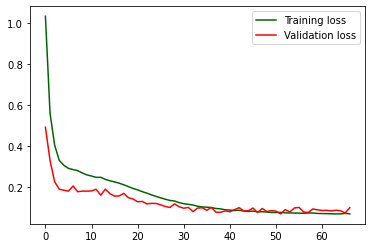

In [16]:
plt.plot(losses['train'], label='Training loss', color='darkgreen')
plt.plot(losses['validation'], label='Validation loss', color='red')
plt.legend()

plt.show()

## Check out your predictions

Here, we use the test data to view how well the network is modeling the data. 

Let's start by calculating the final values for trainig, validation and test losses (traing and validations will be the same as the last calculation from the training step above)

In [17]:
train_loss = MSE(network.run(train_features), train_targets)
print('Train loss:\t ' + str(train_loss)[:5])
val_loss = MSE(network.run(val_features), val_targets)
print('Valid. loss:\t ' + str(val_loss)[:5])
test_loss = MSE(network.run(test_features), test_targets)
print('Test loss:\t ' + str(test_loss)[:5])

Train loss:	 0.066
Valid. loss:	 0.084
Test loss:	 0.066


Now we will plot the predicted values for the test set against the real data:

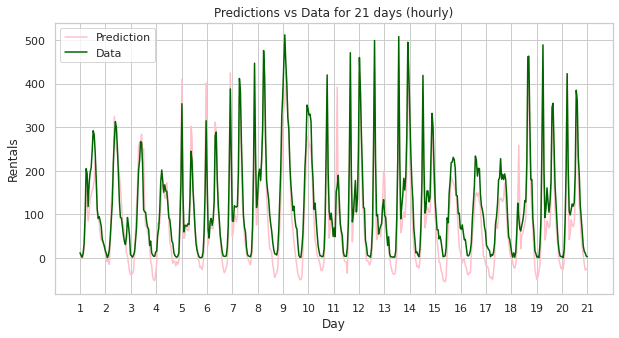

In [18]:
days_plot = int(len(test_features)/24)

xs = np.linspace(1, days_plot, num=len(test_features))
mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean

sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')

plt.figure(figsize=(10,5))

plt.title(f'Predictions vs Data for {days_plot} days (hourly)')
plt.xticks(range(1,days_plot+1))
plt.xlabel('Day')
plt.ylabel('Rentals')
plt.plot(xs, predictions, label='Prediction', color='pink')
plt.plot(xs, (test_targets*std + mean), label='Data', color='darkgreen')
plt.legend()

plt.show()


What if we add up the data in chunks of 24 hours, and create a chart with estimated daily values for our predictions/data? Can this information be meaningful in any way?

One first consideration is to remember that the network was trained with hourly values, but in the original data not all the days had data for the 24 hours, so the chart could look somehow skewed. However if the test loss is low enough we should see a similar behaviod (if somehow skewed in some cases)

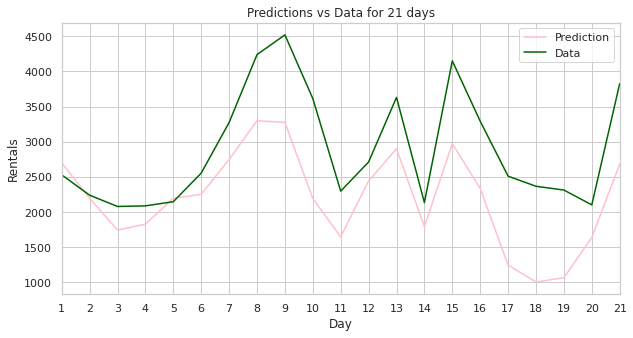

In [19]:
pred, tar = [], []
targets_aux = test_targets*std + mean

for j in range(0, len(predictions), 21):
    pred.append(np.sum(predictions[j:j+24]))
    tar.append(np.sum(targets_aux[j:j+24]))
    
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')

plt.figure(figsize=(10,5))

xs = np.linspace(1, days_plot)
plt.title(f'Predictions vs Data for {days_plot} days')
plt.xticks(range(1,days_plot+1))
plt.xlabel('Day')
plt.ylabel('Rentals')
plt.plot(np.array(pred), label='Prediction', color='pink')
plt.plot(np.array(tar), label='Data', color='darkgreen')
plt.xlim(xmin=1,xmax=21)
plt.legend()

plt.show()


## References
 
* The dataset used here is from [this paper:](https://link.springer.com/article/10.1007/s13748-013-0040-3) 

````
[1] Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.
````
````
@article{
	year={2013},
	issn={2192-6352},
	journal={Progress in Artificial Intelligence},
	doi={10.1007/s13748-013-0040-3},
	title={Event labeling combining ensemble detectors and background knowledge},
	url={http://dx.doi.org/10.1007/s13748-013-0040-3},
	publisher={Springer Berlin Heidelberg},
	keywords={Event labeling; Event detection; Ensemble learning; Background knowledge},
	author={Fanaee-T, Hadi and Gama, Joao},
	pages={1-15}
    }
````


* This project is based on an assignment from the Nanodegree on Deep Learning from [Udacity](https://www.udacity.com/course/deep-learning-nanodegree--nd101)

